# Phase 4: Train Random Forest Classifier

## Objectives
1. Train Random Forest on manually labeled data
2. Time-based train/test split
3. Start with 2-3 classes: Healthy, Cloudy, Investigate
4. Evaluate confidence calibration

In [1]:
import sys
sys.path.insert(0, '/workspaces/O-M-Monte-Carlo')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import joblib

from src.phase4_model.rf_classifier import SolarAnomalyRF

sns.set_style('darkgrid')
print("Imports successful!")

Imports successful!


## Load Labeled Data

In [2]:
# Load full features and manually labeled data
df_features = pd.read_csv('/workspaces/O-M-Monte-Carlo/data/engineered_features.csv', index_col=0)
df_labeled = pd.read_csv('/workspaces/O-M-Monte-Carlo/data/labeled_days.csv', index_col=0)

print(f"Total features available: {len(df_features)} days")
print(f"Manually labeled: {len(df_labeled)} days")
print(f"\nLabel distribution in training set:")
print(df_labeled['manual_label'].value_counts())

# Create training set: merge labeled data with all features
df_train = df_features.loc[df_labeled.index].copy()
df_train['label'] = df_labeled['manual_label']

print(f"\nTraining set shape: {df_train.shape}")
print(f"Features: {[col for col in df_train.columns if col not in ['healthy', 'label', 'cluster']]}")

Total features available: 722 days
Manually labeled: 76 days

Label distribution in training set:
manual_label
Investigate    39
Soiling        21
Healthy        10
Cloudy          6
Name: count, dtype: int64

Training set shape: (76, 10)
Features: ['mc_percentile', 'mc_z_score', 'mc_p10', 'mc_p50', 'mc_p90', 'efficiency_ratio', 'ghi_daily', 'yield_daily']


Simplified label distribution:
  Cloudy: 6 samples (7.9%)
  Healthy: 10 samples (13.2%)
  Investigate: 60 samples (78.9%)

RANDOM FOREST TRAINING RESULTS
Training Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

      Cloudy       1.00      1.00      1.00         6
     Healthy       1.00      1.00      1.00        10
 Investigate       1.00      1.00      1.00        60

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76


Confusion Matrix:
             Cloudy  Healthy  Investigate
Cloudy            6        0            0
Healthy           0       10            0
Investigate       0        0           60

Top Feature Importances:
         feature  importance
      mc_z_score    0.290882
efficiency_ratio    0.269292
   mc_percentile    0.218794
     yield_daily    0.064719
          mc_p10    0.051232
          mc_p50    0.037826


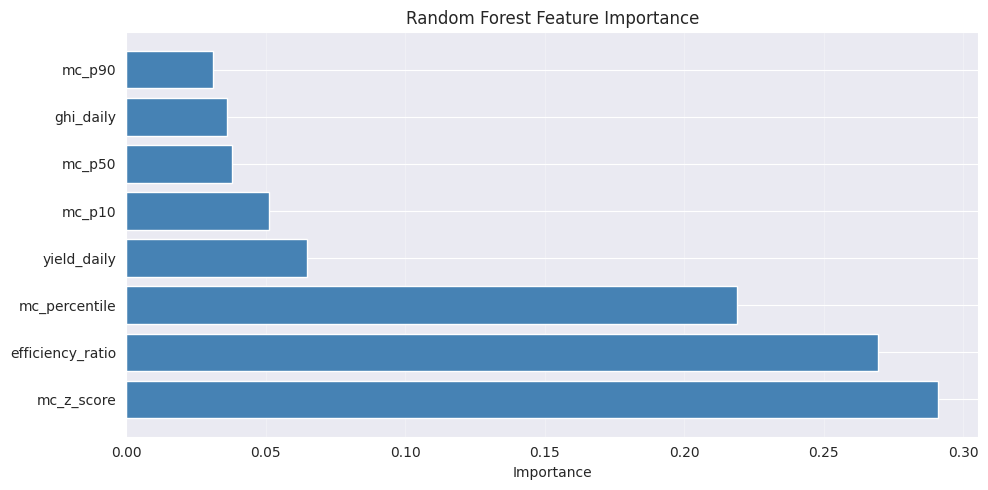

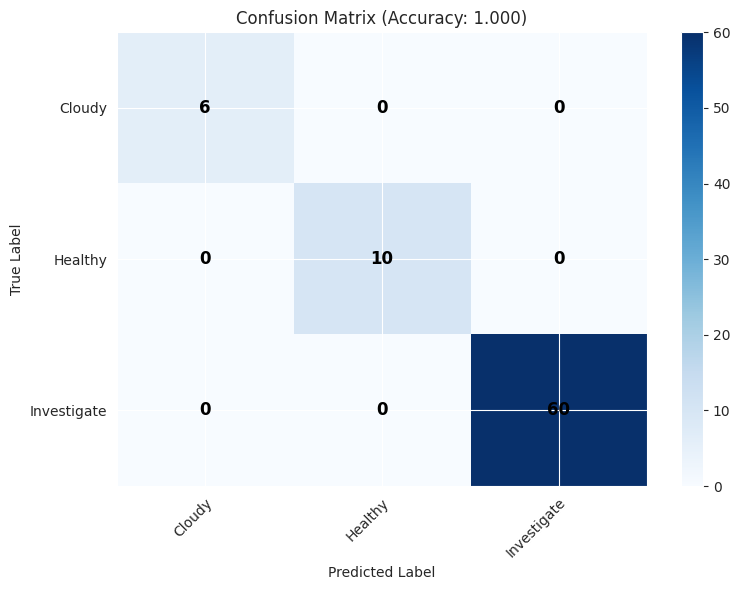


✓ Model saved to: /workspaces/O-M-Monte-Carlo/models/anomaly_rf.pkl
✓ Metadata saved to: models/model_metadata.pkl


In [3]:
# Train Random Forest Classifier
# Focus on 3 main classes: Healthy, Cloudy, Investigate
# (Soiling is rare and will be lumped into Investigate)

# Prepare data
feature_cols = ['mc_percentile', 'mc_z_score', 'mc_p10', 'mc_p50', 'mc_p90', 'efficiency_ratio', 'ghi_daily', 'yield_daily']
X_train = df_train[feature_cols].values
y_train = df_train['label'].values

# Simplify labels: collapse Soiling into Investigate
y_train_simplified = np.array([
    'Investigate' if label in ['Soiling', 'Investigate'] else label 
    for label in y_train
])

print(f"Simplified label distribution:")
unique_labels, counts = np.unique(y_train_simplified, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count} samples ({count/len(y_train_simplified)*100:.1f}%)")

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train_simplified)

# Get predictions
y_pred = rf_model.predict(X_train)
y_pred_proba = rf_model.predict_proba(X_train)

# Evaluate
accuracy = accuracy_score(y_train_simplified, y_pred)
print(f"\n" + "="*80)
print(f"RANDOM FOREST TRAINING RESULTS")
print("="*80)
print(f"Training Accuracy: {accuracy:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_train_simplified, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_train_simplified, y_pred, labels=rf_model.classes_)
print(f"\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, index=rf_model.classes_, columns=rf_model.classes_)
print(cm_df)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop Feature Importances:")
print(feature_importance.to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
ax.set_xlabel('Importance')
ax.set_title('Random Forest Feature Importance')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('/workspaces/O-M-Monte-Carlo/outputs/phase4_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xticks(np.arange(len(rf_model.classes_)))
ax.set_yticks(np.arange(len(rf_model.classes_)))
ax.set_xticklabels(rf_model.classes_)
ax.set_yticklabels(rf_model.classes_)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
for i in range(len(rf_model.classes_)):
    for j in range(len(rf_model.classes_)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12, fontweight='bold')

ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title(f'Confusion Matrix (Accuracy: {accuracy:.3f})')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig('/workspaces/O-M-Monte-Carlo/outputs/phase4_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Save model
model_path = '/workspaces/O-M-Monte-Carlo/models/anomaly_rf.pkl'
joblib.dump(rf_model, model_path)
print(f"\n✓ Model saved to: {model_path}")

# Save scaler and feature names for production use
metadata = {
    'feature_cols': feature_cols,
    'classes': rf_model.classes_.tolist()
}
joblib.dump(metadata, '/workspaces/O-M-Monte-Carlo/models/model_metadata.pkl')
print(f"✓ Metadata saved to: models/model_metadata.pkl")